In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import censusdata
import seaborn as sns
%matplotlib inline  

In [ ]:
#pip install censusdata

# Step 1: Ingest Case Data

There are two excel files of data we'll need for this step.

The first excel file is 'cases_per_zip.xlsx' which has the number of confirmed coronavirus cases in each zip code as of May 16.  I manually assembled this excel spreadsheet by copy/pasting the data available at the four coronavirus dashboards:

Santa Clara: https://www.sccgov.org/sites/covid19/Pages/dashboard.aspx
Alameda: https://ac-hcsa.maps.arcgis.com/apps/opsdashboard/index.html#/332a092bbc3641bd9ec8373e7c7b5b3d
San Francisco: https://data.sfgov.org/stories/s/fjki-2fab
San Mateo: https://www.smchealth.org/post/san-mateo-county-covid-19-data-1

When I did this analysis, these were the only counties offering zip code-level data; but in case that changes, here are the links to the other dashboards:

Contra Costa: https://www.coronavirus.cchealth.org/dashboard
Marin: https://coronavirus.marinhhs.org/surveillance



The second excel file is 'population_per_zip.xlsx', because to get prevalence, you have to divide the number of cases by the population in each zip code.  The data in that file I copy/pasted from here: https://www.california-demographics.com/zip_codes_by_population

In [2]:
cases_per_zip = pd.read_excel('cases_per_zip.xlsx')
population_per_zip = pd.read_excel('population_per_zip.xlsx')
prevalence = pd.merge(cases_per_zip, population_per_zip, on='Zip Code')
prevalence['Cases Per 100k'] = prevalence['Cases'] / prevalence['Population'] * 100000

In [3]:
# And, in case we need it, let's export a new excel spreadsheet with these prevalence numbers.
prevalence.to_csv('cases.xlsx')

# Step 2: Ingest Demographic Data

Working with census data is all about knowing the code that corresponds to your data point, so at first this is going to look like a secret code, but we'll decipher it at the end.

To find new codes, I recommend using the search feature available here: https://censusreporter.org/.
Under the Explore section, you can search for column and table names that seem promising.  

Once you have the table name, search here to get a sense of the layout of the table: https://data.census.gov/cedsci/.

We will be downloading census data at the census-tract level.
There will be an additional step where we roll that data back up to the zip-code level.

In [4]:
county_codes = {'001': 'Alameda', '013': 'Contra Costa', '041': 'Marin', '075': 'San Francisco', 
                '081': 'San Mateo', '085': 'Santa Clara'} 
census_datapoints = ['B01003_001E','B03002_003E', 'B03002_004E', 'B03002_006E', 'B03002_012E', 'B25003_002E',
                                    'B05001_002E', 'B19013_001E', 'B19083_001E', 'B25064_001E', 'B25031_004E',
                                    'B08006_001E', 'B08006_002E', 'B08006_004E', 'B08006_008E', 'B08012_012E',
                                    'B08012_013E', 'B08012_002E', 'B08012_003E', 'B08012_004E', 'B08013_001E',
                                    'B25014_001E', 'B25014_005E', 'B25014_006E', 'B25014_007E', 'B25014_011E',
                                    'B25014_012E', 'B25014_013E', 'B07204_001E', 'B07204_002E', 'B25047_003E', 
                                    'B25047_001E', 'B09002_008E', 'B09002_001E', 'B09010_002E', 'B09010_001E',
                                    'B11007_002E', 'B11007_001E', 'B17026_005E', 'B17026_004E', 'B17026_003E',
                                    'B17026_002E', 'B17026_001E', 'B25003_001E', 'B23025_003E', 'B23025_005E',
                                    'B25109_001E', 'B05001_001E', 'B06009_004E', 'B06009_005E', 'B06009_001E']

county_data = []
for county in county_codes.keys():
    county_data.append(censusdata.download('acs5', 2018, censusdata.censusgeo([('state', '06') , 
                                        ('county',county), ('tract', '*')]), census_datapoints))
df = pd.concat(county_data)
df['Census ID'] = df.index
df['Tract'] = df['Census ID'].apply(lambda x: str(x).split('tract:')[-1]) #.astype(int)
df['County Code'] = df['Census ID'].apply(lambda x: str(x).split('county:')[-1][:3])
df['County'] = df['County Code'].map(county_codes)
df['GEOID'] = ('6' + df['County Code'] + df['Tract'].astype(str)).astype(int)
del df['Census ID']

In [5]:
#for some reason 10 census tracts end up having negative values of median income.  Let's set those tracts =

df[df.B19013_001E < 0] = df[df.B19013_001E > 0].B19013_001E.min()
df[df.B25031_004E < 0] = df[df.B25031_004E > 0].B25031_004E.min()


To this census data, let's append some data about the physical size & location of each census tract.
I got this information from the Gazetteer File Records: 
https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/gaz-record-layouts.html

In [6]:
gazeteer_url = 'https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2019_Gazetteer/2019_gaz_tracts_06.txt'
census_tract_geometry = pd.read_table(gazeteer_url)
df = pd.merge(df,census_tract_geometry[['GEOID', 'ALAND_SQMI']], on='GEOID')
df.rename(columns={'ALAND_SQMI':'Square Miles'}, inplace=True)

Next step is to roll it up to the zip code level, which we do using the HUD Crosswalk files, which tell you how much of each tract is overlapping with each zip code.  The files are here: https://www.huduser.gov/portal/datasets/usps_crosswalk.html#data

But, again, I just copy/pasted them into an excel spreadsheet.  

In [7]:
tract_to_zip = pd.read_excel('TRACT_ZIP_032020.xlsx')
tract_to_zip['GEOID'] = tract_to_zip.TRACT.astype(int)
#tract_to_zip['Tract'] = tract_to_zip.TRACT % 1000000
tract_to_zip['Ratio'] = tract_to_zip.RES_RATIO
tract_to_zip['Zip'] = tract_to_zip.ZIP

df_temp = pd.merge(df,tract_to_zip[['GEOID','Zip','Ratio']], on='GEOID')

#Some of the cesnsus datapoints are absolute numbers, such as total population or total households.
#For those metrics, they need to be combined using a weighted sum.

#Other metrics refer to median values within a tract.  There's no perfect way to roll these up to
#the zip code level, so let's use weighted averages as a proxy.

weighted_average_metrics = ['B19013_001E', 'B25109_001E','B25064_001E','B25031_004E','B19083_001E']
weighted_sum_metrics = list(set(census_datapoints) - set(weighted_average_metrics)) + ['Square Miles']


def weighted_sum(group, column, weight):
    x = group[column]
    w = group[weight]
    return (x * w).sum()

def weighted_avg(group, column, weight):
    x = group[column]
    w = group[weight]
    return (x * w).sum() /  w.sum()

df_zip = pd.DataFrame(df_temp.Zip.unique(), columns = ['Zip'])

for column in weighted_sum_metrics:
    df_zip = pd.merge(df_zip, pd.DataFrame(df_temp.groupby('Zip').apply(weighted_sum, column, 'Ratio'), 
                               columns = [column]), on='Zip')
    
for column in weighted_average_metrics:
    df_zip = pd.merge(df_zip, pd.DataFrame(df_temp.groupby('Zip').apply(weighted_avg, column, 'Ratio'), 
                               columns = [column]), on='Zip')

In [9]:
#And then clean them both up.

for x in [df, df_zip]:
    x['population'] = x['B01003_001E']
    x['frac_white'] = x['B03002_003E'] / x['B01003_001E']
    x['frac_black'] = x['B03002_004E'] / x['B01003_001E']
    x['frac_hispanic'] = x['B03002_012E'] / x['B01003_001E']
    x['frac_asian'] = x['B03002_006E'] / x['B01003_001E']
    x['frac_foreign_born'] = (x['B05001_001E'] - x['B05001_002E']) / x['B05001_001E']
    x['median_household_income'] = np.maximum(0,x['B19013_001E'])
    x['gini_index'] = x['B19083_001E']
    x['frac_unemployed'] = x['B23025_005E'] / x['B23025_003E'] 
    x['frac_below_1.25_poverty'] = (x['B17026_005E'] + x['B17026_004E'] + x['B17026_003E'] 
                        + x['B17026_002E']) / x['B17026_001E'] 
    x['frac_college_plus'] = (x['B06009_004E'] + x['B06009_005E']) / x['B06009_001E']
    x['frac_housing_units_owner_occupied'] = x['B25003_002E'] / x['B25003_001E']
    #x['share_housing_units_vacant'] = x['B25003_002E'] / (x['B25003_002E'] + x['B25003_001E'])
    x['frac_families_moved_last_year'] = (x['B07204_001E'] - x['B07204_002E']) / x['B07204_001E']
    #x['share_housing_lacking_plumbing'] = x['B25047_003E'] / x['B25047_001E']
    x['frac_families_with_single_parent'] = x['B09002_008E'] / x['B09002_001E']
    x['frac_households_SNAP_or_SSI'] = x['B09010_002E'] / x['B09010_001E']
    x['med_house_price'] = np.maximum(0,x['B25109_001E'])
    #x['med_gross_rent'] = np.maximum(0,x['B25064_001E'])
    x['median_rent_2br'] = np.maximum(0,x['B25031_004E'])
    x['frac_households_>1occupant_per_room'] = (x['B25014_005E'] + x['B25014_006E'] + x['B25014_007E']
                        + x['B25014_011E'] + x['B25014_012E'] + x['B25014_013E']) / x['B25014_001E']
    x['frac_households_with_65+'] = x['B11007_002E'] / x['B11007_001E']
    x['avg_occupents_per_housing_unit'] = x['B01003_001E'] / x['B25014_001E']
    x['frac_workers_drive_to_work'] = x['B08006_002E'] / x['B08006_001E']
    x['frac_workers_carpool_to_work'] = x['B08006_004E'] / x['B08006_001E']
    x['frac_workers_public_transit_to_work'] = x['B08006_008E'] / x['B08006_001E']
    x['frac_workers_commute_>1hr'] = (x['B08012_012E'] + x['B08012_013E']) / x['B08006_001E']
    x['frac_workers_commute_<15min'] = (x['B08012_002E'] + x['B08012_003E'] + x['B08012_004E']) / x['B08006_001E']
    x['avg_commute_time_min'] =  np.maximum(0 ,x['B08013_001E'] / x['B08006_001E'])
    x['pop_density'] = x.population / x['Square Miles']
    for name in census_datapoints:
        del x[name]


We have made 2 dataframes: df has all the demographic information at the census tract level, and df_zip has the same information at the zip code level.

Let's join the zip code level data to df_zip so that we can do our analysis.

In [10]:
result = pd.merge(df_zip, prevalence, left_on='Zip', right_on = 'Zip Code')
del result['Cases']
del result['Population']
del result['population']
del result['Zip']
del result['Zip Code']
del result['Square Miles']
del result['County']

In [12]:
# there's a very small number of null rows, so let's just delete them.

#result.isnull().sum()
result = result.dropna()

# Step 3: Analysis — What features correlate with prevalence?

In [16]:
np.round(result.corr()['Cases Per 100k'],2).sort_values(ascending = False)

Cases Per 100k                         1.00
frac_households_SNAP_or_SSI            0.41
frac_families_with_single_parent       0.39
frac_hispanic                          0.38
frac_households_>1occupant_per_room    0.37
frac_below_1.25_poverty                0.35
frac_foreign_born                      0.25
frac_black                             0.23
pop_density                            0.18
frac_workers_public_transit_to_work    0.17
frac_unemployed                        0.16
frac_workers_carpool_to_work           0.09
avg_occupents_per_housing_unit         0.05
avg_commute_time_min                   0.04
gini_index                             0.03
frac_workers_commute_>1hr              0.03
frac_households_with_65+               0.01
frac_asian                            -0.04
frac_workers_drive_to_work            -0.06
frac_workers_commute_<15min           -0.09
med_house_price                       -0.11
frac_families_moved_last_year         -0.13
median_rent_2br                 

Neighborhoods that are the most affected have a high fraction of residents who are: Hispanic, 
below the poverty line, and living in households with >1 occupant per room.
Neighborhoods that are the least affected have a high fraction of residents who are: white, college-educated, and home-owners

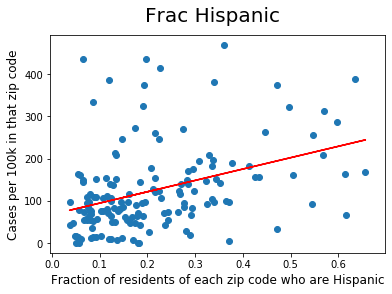

In [17]:
#let's make a few scatter plots

y = result['Cases Per 100k']
x = result.frac_hispanic

linearfit = sm.OLS(y,sm.add_constant(x)).fit()

# print(linearfit.summary())

plt.scatter(x,y)
plt.plot(x, linearfit.fittedvalues, 'r-')
plt.suptitle('Frac Hispanic', fontsize=20)
plt.xlabel('Fraction of residents of each zip code who are Hispanic', fontsize=12)
plt.ylabel('Cases per 100k in that zip code', fontsize=12)


plt.savefig('share_hispanic.pdf')  
plt.show()

How co-linear are these features?

(27.5, -0.5)

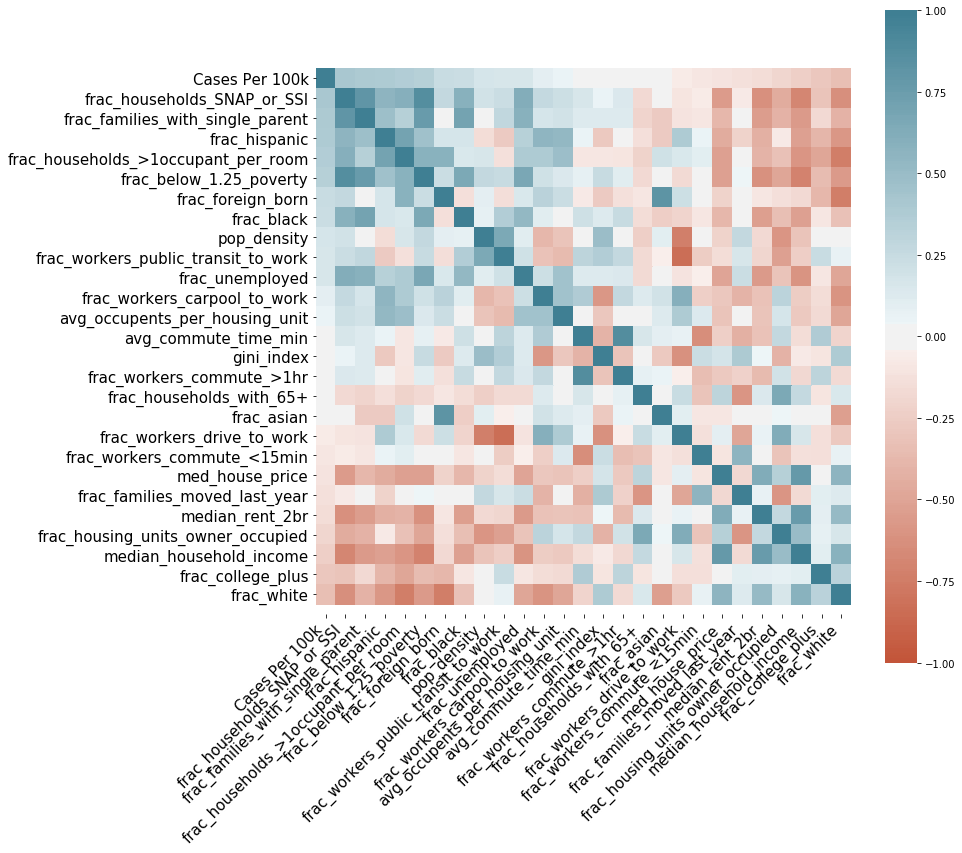

In [18]:
corr = result[['Cases Per 100k', 'frac_households_SNAP_or_SSI', 'frac_families_with_single_parent',
               'frac_hispanic', 'frac_households_>1occupant_per_room','frac_below_1.25_poverty',
              'frac_foreign_born', 'frac_black', 'pop_density', 'frac_workers_public_transit_to_work', 
               'frac_unemployed', 'frac_workers_carpool_to_work',
               'avg_occupents_per_housing_unit','avg_commute_time_min',
              'gini_index', 'frac_workers_commute_>1hr','frac_households_with_65+', 'frac_asian', 
              'frac_workers_drive_to_work', 'frac_workers_commute_<15min', 'med_house_price',
               'frac_families_moved_last_year','median_rent_2br', 'frac_housing_units_owner_occupied',
               'median_household_income', 'frac_college_plus', 'frac_white']].corr()
plt.figure(figsize=(12,12))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=15
)
ax.set_yticklabels(ax.get_yticklabels(),fontsize = 15);
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
#plt.savefig('corr.png')

And here's one column of this heatmap written out explicitly

In [19]:
np.round(result[['Cases Per 100k', 'frac_households_SNAP_or_SSI', 'frac_families_with_single_parent',
               'frac_hispanic', 'frac_households_>1occupant_per_room','frac_below_1.25_poverty',
              'frac_foreign_born', 'frac_black', 'pop_density', 'frac_workers_public_transit_to_work', 
               'frac_unemployed', 'frac_workers_carpool_to_work',
               'avg_occupents_per_housing_unit','avg_commute_time_min',
              'gini_index', 'frac_workers_commute_>1hr','frac_households_with_65+', 'frac_asian', 
              'frac_workers_drive_to_work', 'frac_workers_commute_<15min', 'med_house_price',
               'frac_families_moved_last_year','median_rent_2br', 'frac_housing_units_owner_occupied',
               'median_household_income', 'frac_college_plus', 'frac_white']].corr()['median_household_income'],2)

Cases Per 100k                        -0.23
frac_households_SNAP_or_SSI           -0.68
frac_families_with_single_parent      -0.57
frac_hispanic                         -0.52
frac_households_>1occupant_per_room   -0.59
frac_below_1.25_poverty               -0.71
frac_foreign_born                     -0.18
frac_black                            -0.52
pop_density                           -0.30
frac_workers_public_transit_to_work   -0.25
frac_unemployed                       -0.61
frac_workers_carpool_to_work          -0.26
avg_occupents_per_housing_unit        -0.27
avg_commute_time_min                  -0.15
gini_index                            -0.07
frac_workers_commute_>1hr             -0.18
frac_households_with_65+               0.26
frac_asian                             0.01
frac_workers_drive_to_work             0.17
frac_workers_commute_<15min           -0.13
med_house_price                        0.78
frac_families_moved_last_year         -0.16
median_rent_2br                 

Now let's build a model with a bunch of features

In [20]:
y=result[['Cases Per 100k']]


#X=result[['frac_households_SNAP_or_SSI','frac_college_plus', 'frac_households_with_65+',
#          'median_rent_2br','frac_households_>1occupant_per_room', 'frac_workers_commute_<15min']]

X=result[['frac_households_SNAP_or_SSI', 'frac_college_plus', 'frac_workers_public_transit_to_work',
           'frac_hispanic', 'med_house_price','frac_foreign_born', 'frac_workers_carpool_to_work',
           'frac_households_with_65+', 'frac_black']]

#X=result[['frac_households_SNAP_or_SSI', 'frac_families_with_single_parent',
#               'frac_hispanic', 'frac_households_>1occupant_per_room','frac_below_1.25_poverty',
#              'frac_foreign_born', 'frac_black', 'pop_density', 'frac_workers_public_transit_to_work', 
#               'frac_unemployed', 'frac_workers_carpool_to_work',
#               'avg_occupents_per_housing_unit','avg_commute_time_min',
#              'gini_index', 'frac_workers_commute_>1hr','frac_households_with_65+', 'frac_asian', 
#              'frac_workers_drive_to_work', 'frac_workers_commute_<15min', 'med_house_price',
#               'frac_families_moved_last_year','median_rent_2br', 'frac_housing_units_owner_occupied',
#               'median_household_income', 'frac_college_plus', 'frac_white']]

X=sm.add_constant(X)

In [21]:
olsmodel = sm.OLS(y, X).fit(cov_type = 'HC3')  #
predictions = olsmodel.predict(X)
olsmodel.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Cases Per 100k   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     10.53
Date:                Tue, 09 Jun 2020   Prob (F-statistic):           1.38e-11
Time:                        11:28:57   Log-Likelihood:                -898.15
No. Observations:                 155   AIC:                             1816.
Df Residuals:                     145   BIC:                             1847.
Df Model:                           9                                         
Covariance Type:                  HC3                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                -216.7223    102.169     -2.121      0.034    -416.970     -16.474
frac_households_SNAP_or_SSI            -6.6377    148.732     -0.045      0.964    -298.147     284.872
frac_college_plus                      73.6149    139.849      0.526      0.599    -200.484     347.713
frac_workers_public_transit_to_work   248.3375     69.415      3.578      0.000     112.287     384.388
frac_hispanic                         465.7643    102.726      4.534      0.000     264.426     667.103
med_house_price                       5.67e-05   1.93e-05      2.945      0.003     1.9e-05    9.44e-05
frac_foreign_born                     342.5498     83.125      4.121      0.000     179.628     505.472
frac_workers_carpool_to_work         -803.1568    324.274     -2.477      0.013   -1438.723    -167.591
frac_households_with_65+              220.1738     89.732      2.454      0.014      44.301     396.046
frac_black                            325.0429    165.406      1.965      0.049       0.854     649.232
==============================================================================
Omnibus:                       37.714   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.697
Skew:                           1.181   Prob(JB):                     8.94e-15
Kurtosis:                       5.106   Cond. No.                     4.62e+07
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 4.62e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# what features correlate with the residuals of our model?
df_temp = result
df_temp['residual'] = olsmodel.resid
df_temp.corr().residual.sort_values(ascending=False).astype(str)

residual                                                   1.0
Cases Per 100k                              0.7861023062180447
median_rent_2br                            0.08479936742671922
median_household_income                     0.0587954096532504
frac_white                                 0.04913718844574953
frac_workers_commute_>1hr                   0.0436745224467636
pop_density                                0.04194794883195546
frac_families_with_single_parent          0.038238488048282525
frac_housing_units_owner_occupied         0.013338754889399706
frac_families_moved_last_year             0.012258801924019742
avg_commute_time_min                      0.010531839183817117
med_house_price                          9.833230588692602e-11
frac_households_with_65+                3.0175632014750464e-11
frac_college_plus                       1.5469511414648962e-12
frac_workers_public_transit_to_work    -1.5269044771849354e-11
frac_foreign_born                      -2.1519378300562

Now we can rank census tracts by predicted prevalence:

In [23]:
X_tract=df[['frac_households_SNAP_or_SSI', 'frac_college_plus', 'frac_workers_public_transit_to_work',
           'frac_hispanic', 'med_house_price','frac_foreign_born', 'frac_workers_carpool_to_work',
           'frac_households_with_65+', 'frac_black']]
X_tract=sm.add_constant(X_tract)
predicted_prevalence = np.maximum(0,olsmodel.predict(X_tract))
output = df[['Tract', 'County Code', 'County']].copy() #Lat, Long
output.loc[:,'Predicted Prevalence Per 100k'] = predicted_prevalence
output = pd.merge(output, df[['Tract', 'frac_households_SNAP_or_SSI', 'frac_college_plus', 'frac_workers_public_transit_to_work',
           'frac_hispanic', 'med_house_price','frac_foreign_born', 'frac_workers_carpool_to_work',
           'frac_households_with_65+', 'frac_black']], on='Tract')

In [24]:
output.sort_values(by = 'Predicted Prevalence Per 100k')
output.to_excel('output.xlsx')


# Step 4: Analysis — How much variance is there at the tract level?

In [25]:
df_zip[df_zip.Zip == 94611].median_household_income

1    124534.570993
Name: median_household_income, dtype: float64

In [26]:
df_temp = pd.merge(df,tract_to_zip[['GEOID','ZIP','Ratio']], on='GEOID')

In [27]:
#Here are the median incomes in all of the census tracts that overlap a single zip code.  That's a lot of variation!
df_temp[df_temp.ZIP == 94611].median_household_income

1      181000
158     44107
212    158239
217    173864
222    178922
235     89982
287    167077
291     94732
402    106250
411     83114
412    189044
481     44803
483     70526
489     93721
490     80077
679    123571
Name: median_household_income, dtype: int64

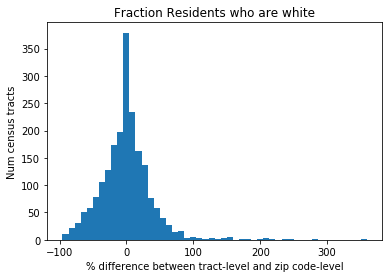

In [28]:
#Let's make a histogram over all zip codes.
mess = 100 * df_temp['frac_white'].sub(df_temp.groupby('ZIP')['frac_white'].transform('mean')).div(df_temp.groupby('ZIP')['frac_white'].transform('mean'))
plt.hist(mess, bins = 50) 
plt.title("Fraction Residents who are white") 
plt.xlabel('% difference between tract-level and zip code-level')
plt.ylabel('Num census tracts')
plt.savefig('diff10.pdf')
plt.show()

In [29]:
abs(mess).mean()

26.85259110399161

# Step 5: make some maps

In [36]:
from os import makedirs
from os.path import exists, join
import re
import requests
import geopandas as gpd

To make heatmaps of the Bay Area, we need to download "shapefiles" from the census website that describe the shape of every census tract, zip code, and county.

In [38]:
# make a directory to put the shapefiles in
makedirs('shapefiles', exist_ok=True)
DEST_FNAME = 'shapefiles'

In [41]:
#I'm commenting out the zip code line because they take the most time to download, 
#but if you want to make zip code level maps, make sure to add them back in.

fnames = ['shapefiles/tract_shapefiles.zip', 
          'shapefiles/county_shapefiles.zip'] #  'shapefiles/zip_shapefiles.zip'

urls = ['https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_06_tract_500k.zip',
        'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_5m.zip']
        #'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_zcta510_500k.zip'

DEST_FNAMES = [join('shapefiles', 'tracts.csv'), join('shapefiles', 'counties.csv')] #join('shapefiles', 'zips.csv'), 

for i in range(len(fnames)):
    url = urls[i]
    fname = fnames[i]
    if not exists(fname):
       print("Downloading", url)
       zresp = requests.get(url)
       with open(fname, 'wb') as w:
          print("\tWriting", fname)
          w.write(zresp.content)
    else:
        print("Already have", fname)

Already have shapefiles/tract_shapefiles.zip
Already have shapefiles/county_shapefiles.zip


In [43]:
d_tract = gpd.read_file('zip://' + fnames[0])
d_county = gpd.read_file('zip://'+ fnames[1])
#d_zip = gpd.read_file('zip://'+ fnames[2])

tract_shapes = gpd.GeoDataFrame(d_tract)
tract_shapes.to_file(DEST_FNAME[0], driver='GeoJSON')

county_shapes = gpd.GeoDataFrame(d_county)
county_shapes.to_file(DEST_FNAME[1], driver='GeoJSON')

#zip_shapes = gpd.GeoDataFrame(d_zip)
#zip_shapes.to_file(DEST_FNAME, driver='GeoJSON')

tract_shapes = tract_shapes[tract_shapes['COUNTYFP'].isin(county_codes.keys())]
tract_shapes = tract_shapes.reset_index()

county_shapes = county_shapes[(county_shapes.STATEFP == '06') & (county_shapes['COUNTYFP'].isin(county_codes.keys()))]

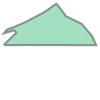

In [45]:
tract_shapes['geometry'][24]

Make a plot of Frac Hispanic in each census tract

In [47]:
tract_shapes['GEOID'] = tract_shapes.GEOID.astype(int)
new_df = pd.merge(tract_shapes[['GEOID', 'geometry']], df, how='left', on='GEOID') #, how = 'left'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


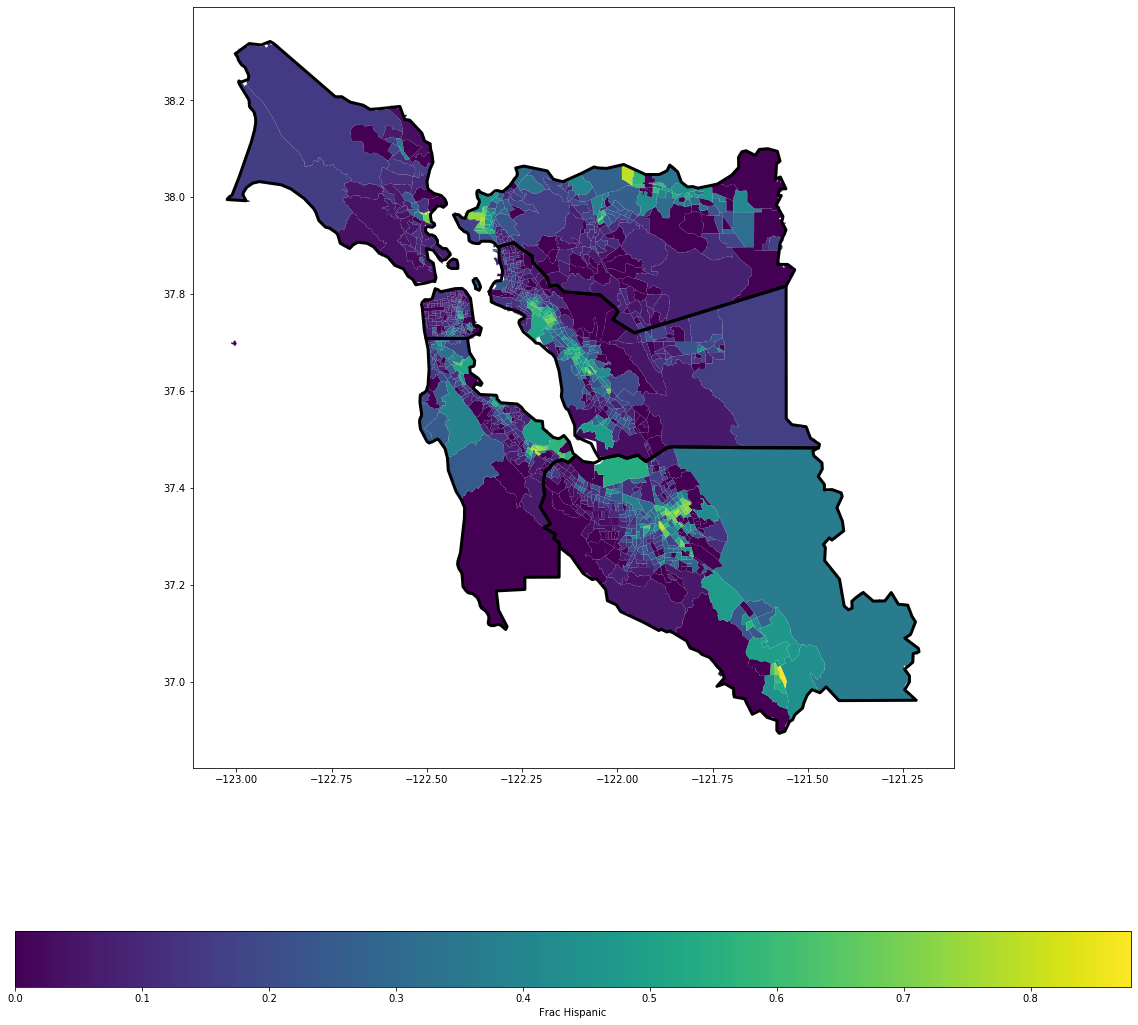

In [48]:
new_df['frac_hispanic'].fillna(0,inplace = True)

fig, ax = plt.subplots( figsize=(20,20)) 

new_df.plot(ax=ax,column = 'frac_hispanic', figsize=(20,20), linewidth=0.25, #, ax=ax,  
        legend=True, legend_kwds={'label': "Frac Hispanic",'orientation': "horizontal"})

county_shapes.plot(ax=ax,facecolor="none", edgecolor='black', lw=3)
ax.set_aspect(1./ax.get_data_ratio())
fig.show()

In [49]:
output['GEOID'] = ('06' + output['County Code'] + output['Tract']).astype(int)

In [50]:
tract_shapes['GEOID'] = tract_shapes.GEOID.astype(int)
new_df = pd.merge(tract_shapes[['GEOID', 'geometry']], output, how='left', on='GEOID') #, how = 'left'

In [51]:
len(new_df)

1347

In [52]:
county_codes

{'001': 'Alameda',
 '013': 'Contra Costa',
 '041': 'Marin',
 '075': 'San Francisco',
 '081': 'San Mateo',
 '085': 'Santa Clara'}

Make a plot of the predicted prevalence in each census tract in Santa Clara

/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:335: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


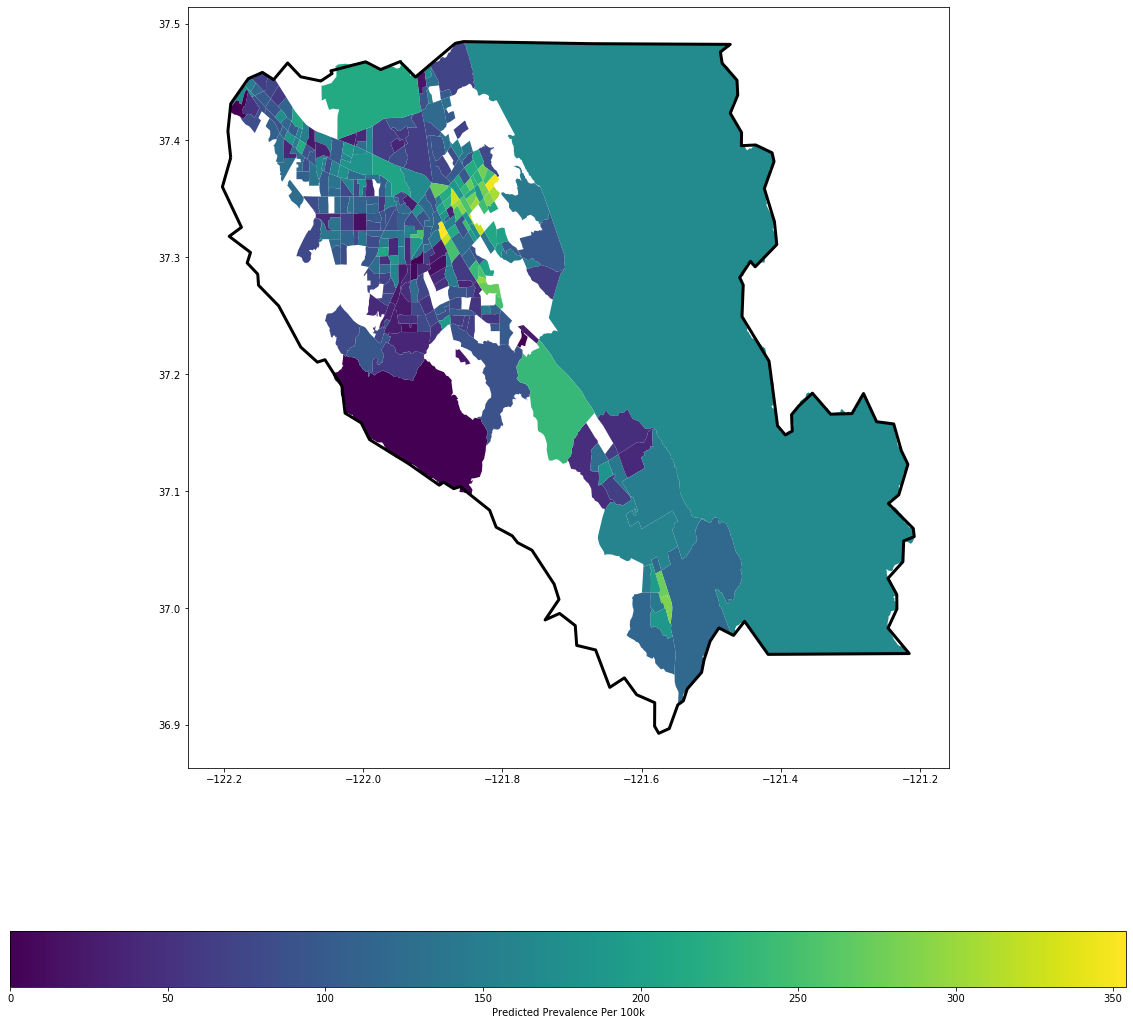

In [53]:
fig, ax = plt.subplots( figsize=(20,20)) 

new_df_sub = new_df[new_df['County Code'] == '085']
county_shapes_sub = county_shapes[county_shapes['COUNTYFP'] == '085']


new_df_sub.plot(ax=ax,column = 'Predicted Prevalence Per 100k', figsize=(20,20), linewidth=0.25, #, ax=ax,  
        legend=True, legend_kwds={'label': "Predicted Prevalence Per 100k",'orientation': "horizontal"},
           missing_kwds={"color": "grey","label": "Missing values"})

county_shapes_sub.plot(ax=ax,facecolor="none", edgecolor='black', lw=3)
ax.set_aspect(1./ax.get_data_ratio())
fig.show()

plt.savefig('santaclara.png', dpi=300)

<Figure size 432x288 with 0 Axes>